### Project 4: Machine Learning
#### Montgomery College DATA201 Spring 2019  [Steve Dutky](sdutky@gmail.com)
The fourth project will be on a machine learning algorithm of your choice:
 Decision Trees, K-Means, or Neural Networks
You can work on datasets of your choice.

### Where murders go unsolved:

From an investigation of unsolved murders appearing in the Washington Post on June 6, 2018.

The Washington Post compiled up to a decade of homicide arrest data from 50 of America’s largest cities.

The Post mapped and analyzed the data to identify the homicides that most often led to an arrest and those that did not.

Homicide arrest rates were calculated by victim’s race, age, gender and location. The Post’s data, which provides a level of specificity lacking in the homicide data released annually by the FBI, is being released publicly and will be expanded over 2018.

[article](https://www.washingtonpost.com/graphics/2018/investigations/where-murders-go-unsolved/?utm_term=.f1f4fb421d93)
[data](https://github.com/washingtonpost/data-homicides/raw/master/homicide-data.csv)
[maps](https://www.washingtonpost.com/graphics/2018/investigations/unsolved-homicide-database/)
<p>
    <a href="http://data.indy.gov/">OpenIndy Data Portal</a>
<p>
 <a href="https://opendata.arcgis.com/datasets/dab5051ee2e243e3a4a7a6fc9033325d_2.zip">Indianapolis Census Tracts shapefiles</a>

## This project's intent is to use a K-Means machine learning process to identify clusters of homicides in Indianapolis

#### The data in each observation:

* <B>uid</B>
    unique identifier formed from a city abbreviation and integer
* <B>reported_date</B>
    a numeric date in the form (mostly) YYYYMMDD
* <B>victim_last</B>
    string last name ignored here
* <B>victim_first</B>
    string first name ignored here
* <B>victim_race</B>
    string category
* <B>victim_age</B>
    string category
* <B>victim_sex</B>
    string category
* <B>city</B>
    string city full name
* <B>state</B>
    string state abbreviation
* <B>lat</B>
    float victim location latitude in decimal degrees
* <B>lon</B>
    float victim location lattitude in decimal degrees
* <B>disposition</B>
    string category:
        "Closed by arrest"
        "Closed without arrest"  exceptional circumstance is. suspect died
        "Open/No arrest"

#### There are 52,179 cases with 60 NA's in latitude and longitude

### python/jupyter initialization:

#### required packages:
<p>conda install geopandas

#### directory 'shapefile' must be writeable in the current working directory



In [3]:
## import packages:
import random # library of function for generating random numbers and samples
import numpy as np # for vector operations
import pandas as pd # for Data Frame methods
import matplotlib.pyplot as plt # Two dimensional plotting library
import seaborn as sns
from scipy import stats #  library of statistical functions
from sklearn.cluster import KMeans

import geopandas as gpd
import requests
import zipfile
import io

#
# Set seed for generating psuedo random numbers
np.random.seed(12345678)
#
# Set up graphics
plt.style.use('classic')

%matplotlib notebook
%matplotlib notebook
# repeated by way of reported bug
%matplotlib notebook
%matplotlib notebook
plt.rcParams["figure.figsize"] = (12, 8)


### Get csv from Washington Post's github site

In [4]:

murder=pd.read_csv("https://github.com/washingtonpost/data-homicides/raw/master/homicide-data.csv",encoding='latin1')

murder.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52179 entries, 0 to 52178
Data columns (total 12 columns):
uid              52179 non-null object
reported_date    52179 non-null int64
victim_last      52178 non-null object
victim_first     52179 non-null object
victim_race      52179 non-null object
victim_age       52179 non-null object
victim_sex       52179 non-null object
city             52179 non-null object
state            52179 non-null object
lat              52119 non-null float64
lon              52119 non-null float64
disposition      52179 non-null object
dtypes: float64(2), int64(1), object(9)
memory usage: 4.8+ MB


### Drop 60 nan's in Longitude and Latitude

In [5]:
murder.dropna(inplace=True)
murder.index=[i for i in range(murder.shape[0])]
murder.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52118 entries, 0 to 52117
Data columns (total 12 columns):
uid              52118 non-null object
reported_date    52118 non-null int64
victim_last      52118 non-null object
victim_first     52118 non-null object
victim_race      52118 non-null object
victim_age       52118 non-null object
victim_sex       52118 non-null object
city             52118 non-null object
state            52118 non-null object
lat              52118 non-null float64
lon              52118 non-null float64
disposition      52118 non-null object
dtypes: float64(2), int64(1), object(9)
memory usage: 5.2+ MB


### Note reported_date in 20,151

In [6]:
print(murder.describe().T)

                 count          mean           std           min  \
reported_date  52118.0  2.013091e+07  1.124076e+06  2.007010e+07   
lat            52118.0  3.702673e+01  4.348670e+00  2.572521e+01   
lon            52118.0 -9.147126e+01  1.374646e+01 -1.225078e+02   

                        25%           50%           75%           max  
reported_date  2.010032e+07  2.012122e+07  2.015091e+07  2.015111e+08  
lat            3.376518e+01  3.852491e+01  4.002763e+01  4.505119e+01  
lon           -9.599721e+01 -8.771029e+01 -8.175569e+01 -7.101152e+01  


### Rename columns for my convenience

In [7]:
murder.columns=['uid', 'date', 'victim_last', 'victim_first', 'race',
       'age', 'sex', 'city', 'state', 'lat', 'lon',
       'disposition']
murder.columns

Index(['uid', 'date', 'victim_last', 'victim_first', 'race', 'age', 'sex',
       'city', 'state', 'lat', 'lon', 'disposition'],
      dtype='object')

### See variety and distribution of categroical data

In [8]:
print(murder['disposition'].value_counts(),"\n\n",
      murder['race'].value_counts(),"\n\n",
      murder['sex'].value_counts(),"\n\n",
      murder['age'].value_counts().head()
    )

Closed by arrest         25647
Open/No arrest           23556
Closed without arrest     2915
Name: disposition, dtype: int64 

 Black       33332
Hispanic     6888
White        6319
Unknown      4198
Other         698
Asian         683
Name: race, dtype: int64 

 Male       40696
Female      7192
Unknown     4230
Name: sex, dtype: int64 

 Unknown    2997
22         2115
21         2091
23         2058
24         1994
Name: age, dtype: int64


### Begin cleaning: extract homicides in Indianapolis

In [9]:
df=murder[murder.city=="Indianapolis"].copy()
df.index=[ i for i in range(df.shape[0])]

df.info()




<class 'pandas.core.frame.DataFrame'>
Int64Index: 1322 entries, 0 to 1321
Data columns (total 12 columns):
uid             1322 non-null object
date            1322 non-null int64
victim_last     1322 non-null object
victim_first    1322 non-null object
race            1322 non-null object
age             1322 non-null object
sex             1322 non-null object
city            1322 non-null object
state           1322 non-null object
lat             1322 non-null float64
lon             1322 non-null float64
disposition     1322 non-null object
dtypes: float64(2), int64(1), object(9)
memory usage: 134.3+ KB


### Recode ages to age ranges

In [10]:
b=[int(i) if i!="Unknown" else 0 for i in df.age ]

print(max(b))

mapAge={}
for i in range(max(b)+1):
        if i==0:
                mapAge[i]="Unknown"
        elif i>0 and i<6:
                mapAge[i]="1to5"
        elif i>5 and i<12:
                mapAge[i]="6to11"
        elif i>11 and i<16:
                mapAge[i]="12to15"
        elif i>15 and i<20:
                mapAge[i]="16to19"
        elif i>19 and i<26:
                mapAge[i]="20to25"
        elif i>25 and i<36:
                mapAge[i]="26to35"
        elif i>35 and i<46:
                mapAge[i]="36to45"
        elif i>45 and i<56:
                mapAge[i]="46to55"
        elif i>55 and i<66:
                mapAge[i]="56to65"
        else:
                mapAge[i]="66andOlder"

df['age']=[mapAge[i] for i in b]

df['age'].value_counts()






89


26to35        371
20to25        315
36to45        217
46to55        131
16to19        123
56to65         65
66andOlder     37
1to5           21
12to15         19
Unknown        17
6to11           6
Name: age, dtype: int64

### Get Indianapolis Census Tract Map from OpenIndy

In [11]:
# get shapefile archive from OpenIndy
import requests
import zipfile

r = requests.get('https://opendata.arcgis.com/datasets/dab5051ee2e243e3a4a7a6fc9033325d_2.zip')
z = zipfile.ZipFile(io.BytesIO(r.content))

z.extractall(path='shapefile/') # extract to folder
filenames = [y for y in sorted(z.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
print(filenames)

['2010_Census_Tracts.dbf', '2010_Census_Tracts.prj', '2010_Census_Tracts.shp', '2010_Census_Tracts.shx']


### Geographical Detour: Using geopandas to plot maps

GeoPandas is a project to add support for geographic data to pandas objects.

The goal of GeoPandas is to make working with geospatial data in python easier. It combines the capabilities of pandas and shapely, providing geospatial operations in pandas and a high-level interface to multiple geometries to shapely. GeoPandas enables you to easily do operations in python that would otherwise require a spatial database such as PostGIS. <a href="https://pypi.org/project/geopandas/">Geographic pandas extensions</a>

In particular, geopandas has methods for reading shapefiles produced by Geographic Information Systems (GIS), such as ArcGIS from ESRI. All sorts of shapefiles deaking with all manner of subjects can be downloaded from repositories maintained by government, academia, industry, and the kid next door.

Additionally, geopandas's graphic methods interoperate well with mathplotlib. You can mix and match these to handle titles, labels, and legends, as wwll as layering data plotted with mathplotlib calls on top of geopandas's maps.

#### GeoDataFrame, geometry column, and GeoSeries

The geopandas read_file method takes a shapefile argument (among others) and returns a GeoDataFrame. This behaves like a pandas DataFrame but includes a column named geometry.  The geometry column contains a GeoSeries. Each element of the GeoSeries consists of a spatial feature which is one of polygon, lines, or points and the set of longitude and latitude pairs of each vertex of the feature.

Here we are interested in polygons

In [12]:
print(filenames)

import geopandas as gpd

dbf, prj, shp, shx = [filename for filename in filenames]
indy = gpd.read_file('shapefile/'+shp)
indy.head()




['2010_Census_Tracts.dbf', '2010_Census_Tracts.prj', '2010_Census_Tracts.shp', '2010_Census_Tracts.shx']


,OBJECTID,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,SHAPEAREA,SHAPELEN,geometry
0,86,18,097,340201,18097340201,3402.01,Census Tract 3402.01,G5020,S,1943811,0,+39.8164379,-086.2630237,2.086925e+07,18492.425768,POLYGON ((-86.25585015669203 39.80965355895577...
1,87,18,097,340202,18097340202,3402.02,Census Tract 3402.02,G5020,S,2178296,0,+39.8017480,-086.2598831,2.360219e+07,21252.462778,POLYGON ((-86.26328415805597 39.80938955854848...
2,88,18,097,340300,18097340300,3403,Census Tract 3403,G5020,S,3235045,0,+39.8132631,-086.2477454,3.481444e+07,24957.427723,"POLYGON ((-86.24010315304895 39.823976562749, ..."
3,89,18,097,340400,18097340400,3404,Census Tract 3404,G5020,S,1947893,0,+39.8167298,-086.2329492,2.099752e+07,18489.095364,POLYGON ((-86.22698714431147 39.82415165694484...
4,90,18,097,340500,18097340500,3405,Census Tract 3405,G5020,S,3909454,12776,+39.8186204,-086.2129746,4.160564e+07,26748.466240,POLYGON ((-86.19734856246487 39.82449429744264...


#### drilling down on the geometry of indy[0]:

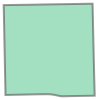

In [13]:
indy.geometry[0]

In [14]:

from shapely.geometry import mapping

print("indy[0] geometry feature type is",mapping(indy.geometry[0])['type'])
all_coords = mapping(indy.geometry[0])["coordinates"]
all_coords[0][0:10]


indy[0] geometry feature type is Polygon


((-86.25585015669203, 39.80965355895577),
 (-86.25584067984109, 39.809152746583685),
 (-86.26057783653783, 39.809067184951374),
 (-86.26070292276337, 39.809058659677724),
 (-86.26082824110046, 39.80905484411744),
 (-86.26095361428307, 39.80905574366774),
 (-86.26107886496763, 39.80906135705617),
 (-86.26120381598379, 39.809071676342455),
 (-86.26142415765368, 39.80910755840543),
 (-86.2615701577933, 39.80913555846822))

<IPython.core.display.Javascript object>


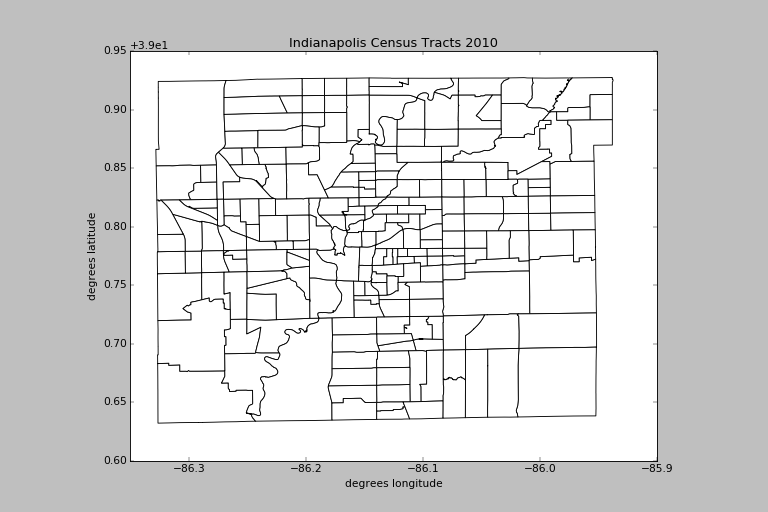

In [15]:
#plt.figure()
indy.plot(color='white',edgecolor='black')

plt.title('Indianapolis Census Tracts 2010')
plt.xlabel('degrees longitude')
plt.ylabel('degrees latitude')
plt.show()

<IPython.core.display.Javascript object>


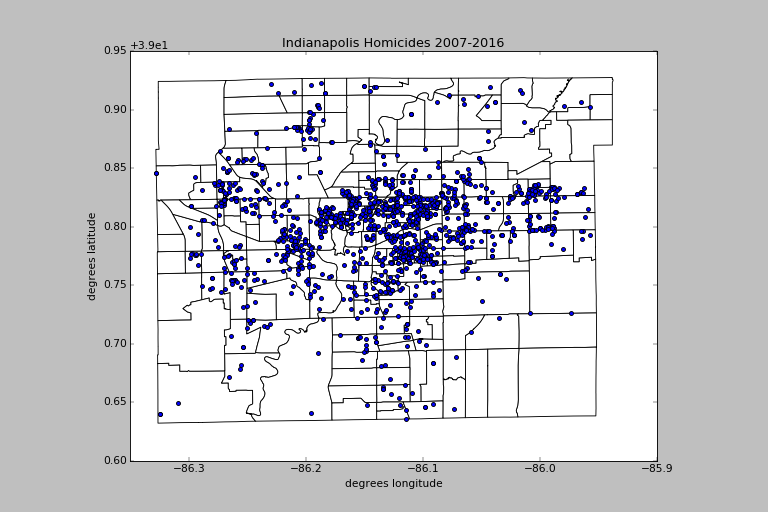

In [16]:
#plt.figure()
indy.plot(color='white',edgecolor='black')
plt.scatter(df.lon,df.lat)
plt.title('Indianapolis Homicides 2007-2016')
plt.xlabel('degrees longitude')
plt.ylabel('degrees latitude')
plt.show()

### Plot Indianapolis homicides per census tract:

#### We need to find where the location of the homicide fits in polygon boundary of the census tract

In [17]:
# import libraries that provide methods for relating points to polygons
from shapely.geometry import Point, Polygon

homicides=np.zeros(indy.shape[0])
for i in range(indy.shape[0]):
    tract=indy.geometry[i]
    for p in range(df.shape[0]):
        point=Point(df.lon[p],df.lat[p])
        homicides[i]+=int(point.within(tract))
        
indy['homicides']=homicides

<IPython.core.display.Javascript object>


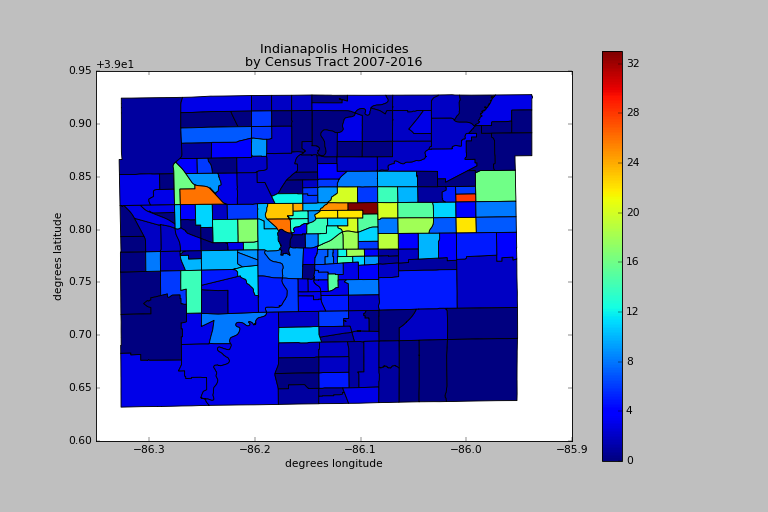

In [18]:

#plt.figure()
indy.plot(column='homicides',  legend=True)

plt.title('Indianapolis Homicides\nby Census Tract 2007-2016')
plt.xlabel('degrees longitude')
plt.ylabel('degrees latitude')
plt.show()


## Back to Kmeans:



### How many clusters to choose: the Elbow Method
#### KMeans requuires that you specify the number of clusters to form:


"The idea behind elbow method is to run k-means clustering on a given dataset for a range of values of k (num_clusters, e.g k=1 to 10), and for each value of k, calculate sum of squared errors (SSE).

After that, plot a line graph of the SSE for each value of k. If the line graph looks like an arm.... the "elbow" on the arm is the value of optimal k (number of cluster). Here, we want to minimize SSE. SSE tends to decrease toward 0 as we increase k (and SSE is 0 when k is equal to the number of data points in the dataset, because then each data point is its own cluster, and there is no error between it and the center of its cluster).

So the goal is to choose a small value of k that still has a low SSE, and the elbow usually represents where we start to have diminishing returns by increasing k." [Om Prakash, stackexchane](https://stackoverflow.com/a/41525972/4984018)

<IPython.core.display.Javascript object>


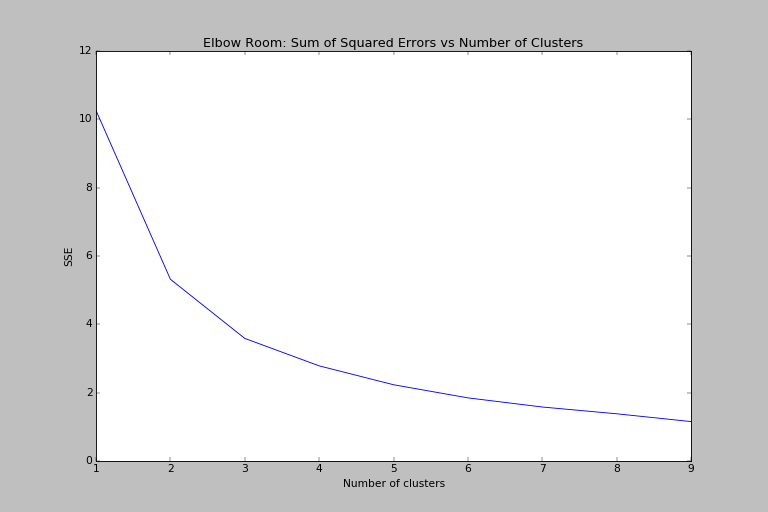

In [19]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df[['lon','lat']])
    
    sse[k]=kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    


plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.title('Elbow Room: Sum of Squared Errors vs Number of Clusters')
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()


### Change in slope levels out after 3: therefore use 3 clusters for KMeans

<IPython.core.display.Javascript object>


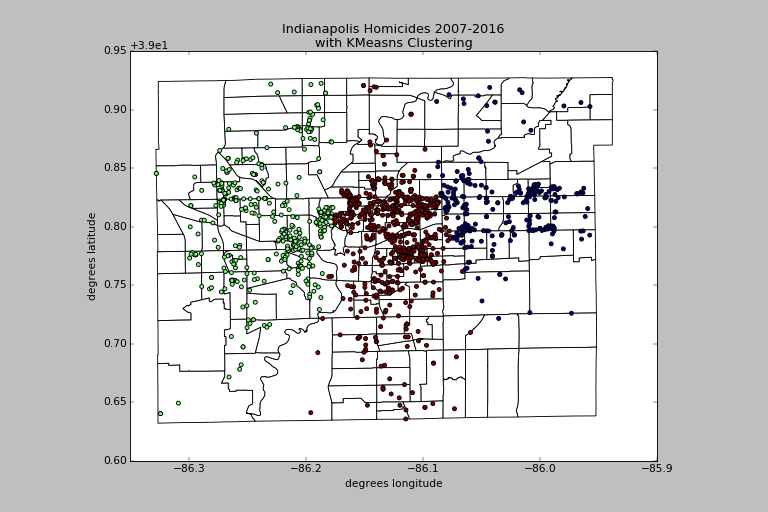

In [20]:
# instantiate and fit KMeans for three clusters
km=KMeans(n_clusters=3,max_iter=1000).fit(df[['lon','lat']])
#plt.figure()
# plot indy census tracts
indy.plot(color='white',edgecolor='black')
# plot scatter plot of homicides, with cluster identified by color

plt.scatter(df.lon,df.lat,c=km.labels_.astype(np.float),edgecolor='k')
plt.title('Indianapolis Homicides 2007-2016\nwith KMeasns Clustering')
plt.xlabel('degrees longitude')
plt.ylabel('degrees latitude')
plt.show()

### KMeans has limitations
* It places all points in cluster regardless of any outliers
* User must specify the number of clusters to use
* It uses Euclidean distance as a cluster metric; does not work well for geocoordinates

### DBSCAN alternative has some attractive features
* It figures out the number of clusters
* You can specify the maximum distance from centroid and the minimum number of cluster members
* Choice of metrics including great circle distance and roll your own

In [21]:
# code mainly stolen from https://github.com/gboeing/data-visualization/blob/master/location-history/google-location-history-cluster.ipynb

from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from datetime import datetime as dt

# define the number of kilometers in one radian
kms_per_radian = 6371.0088

In [22]:
coords = df[['lat','lon']].values
epsilon=.12/kms_per_radian # cluster radius of approx 1 city block

db = DBSCAN(eps=epsilon, min_samples=3, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
print('Number of clusters: {:,}'.format(num_clusters))

Number of clusters: 85


In [23]:
clustered=[ i for i in  range(db.labels_.shape[0]) if db.labels_[i]>0 ]
a=pd.DataFrame(db.labels_[clustered])
a.describe()

,0
count,300.000000
mean,39.996667
std,23.716906
min,1.000000
25%,19.000000
50%,39.000000
75%,60.000000
max,83.000000


<IPython.core.display.Javascript object>


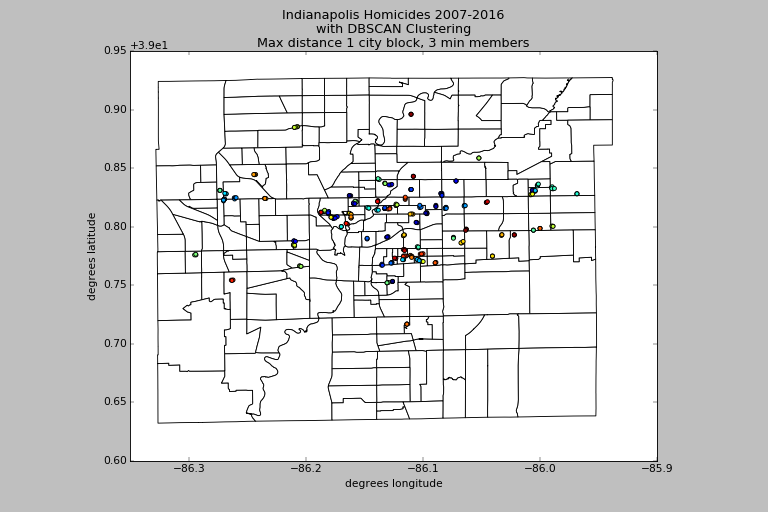

In [24]:
# plot indy census tracts
indy.plot(color='white',edgecolor='black')
# plot scatter plot of homicides, with cluster identified by color

plt.scatter(df.lon[clustered],df.lat[clustered],c=db.labels_[clustered].astype(np.float),edgecolor='k')
plt.title('Indianapolis Homicides 2007-2016\nwith DBSCAN Clustering\nMax distance 1 city block, 3 min members')
plt.xlabel('degrees longitude')
plt.ylabel('degrees latitude')
plt.show()

In [25]:
help(DBSCAN)

Help on class DBSCAN in module sklearn.cluster.dbscan_:

class DBSCAN(sklearn.base.BaseEstimator, sklearn.base.ClusterMixin)
 |  DBSCAN(eps=0.5, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
 |  
 |  Perform DBSCAN clustering from vector array or distance matrix.
 |  
 |  DBSCAN - Density-Based Spatial Clustering of Applications with Noise.
 |  Finds core samples of high density and expands clusters from them.
 |  Good for data which contains clusters of similar density.
 |  
 |  Read more in the :ref:`User Guide <dbscan>`.
 |  
 |  Parameters
 |  ----------
 |  eps : float, optional
 |      The maximum distance between two samples for them to be considered
 |      as in the same neighborhood.
 |  
 |  min_samples : int, optional
 |      The number of samples (or total weight) in a neighborhood for a point
 |      to be considered as a core point. This includes the point itself.
 |  
 |  metric : string, or callable
 |      